In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import quandl
import pickle
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
api_key = '764-Cog1Q3xa6Rns5pmj'
quandl.ApiConfig.api_key = api_key
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [4]:
con, meta = connect('postgres', '', 'robotdb')
    
tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('screen', String, primary_key = True)
                
        
)

macd = Table('Macd', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('ema12', Float),
    Column('ema_26', Float),
    Column('macd_line', Float),
    Column('signal_line', Float),
    Column('histogram', Float),
    Column('screen', Integer, primary_key=True)
)

boillinger = Table('Boillinger', meta,
                       Column('date', DateTime, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('upper_band', Float),
                       Column('lower_band', Float),
                       Column('sma20', Float),
                       Column('height', Float),
                       Column('screen', Integer, primary_key=True)
                       )

ema = Table('Ema', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('ema5', Float),
                Column('ema20', Float),
                Column('ema5_theta', Float),
                Column('ema20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

long_positions = Table('Long', meta,
                       Column('id_position', Integer, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('strategy', String),
                       Column('size_position', Float),
                       Column('date_ask', DateTime),
                       Column('ask', Float),
                       Column('date_settlement', DateTime),
                       Column('settlement', Float),
                       Column('take_profit', Float),
                       Column('stop_loss', Float),
                       Column('exit_date', DateTime),
                       Column('exit_price', Float),
                       Column('log_return', Float),
                       Column('status', String)
                       )


mkt_trend = Table('Market_trend', meta,
                  Column('coin', String, primary_key=True),
                  Column('date', DateTime, primary_key=True),
                  Column('screen', Integer, primary_key=True),
                  Column('dif_current', Float),
                  Column('dif_base', Float),
                  Column('delta_dif', Float),
                  Column('vote', Integer)
                  )

rsi = Table('Rsi', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('rsi', Float),
    Column('screen', Integer, primary_key=True)
)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
# Create the above tables
# meta.create_all(con)

In [5]:
def get_macds(coin, date, screen):
    s = select([macd])\
        .where(and_(macd.c.coin == coin, macd.c.date <= date, macd.c.screen==screen))\
        .order_by(desc(macd.c.date))
    rows = con.execute(s)
    macd_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not macd_df.empty:
        macd_df.columns = rows.keys()
    return macd_df

def get_tickers(coin, date, screen):
    s = select([tickers])\
        .where(and_(tickers.c.coin == coin, tickers.c.date <= date, tickers.c.screen == screen))\
        .order_by(
        desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not tickers_df.empty:
        tickers_df.columns = rows.keys()
    return tickers_df

def get_positions(coin, status, date):
    s = select([long_positions]) \
        .where(and_(long_positions.c.coin == coin,
                    long_positions.c.date_ask <= date,
                    long_positions.c.status == status))\
        .order_by(desc(long_positions.c.date_ask))
    rows = con.execute(s)
    long_positions_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not long_positions_df.empty:
        long_positions_df.columns = rows.keys()
    return long_positions_df

def get_emas(coin, date, screen):
    s = select([ema])\
        .where(and_(ema.c.coin == coin, ema.c.date <= date, ema.c.screen == screen))\
        .order_by(ema.c.date.desc())
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not ema_df.empty:
        ema_df.columns = rows.keys()
    return ema_df

def get_mkt_trend(coin, date, screen):
    s = select([mkt_trend]).\
        where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
        order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    return mkt_trend_df

In [6]:
def plot_market_trend(coin,start_date = datetime.today().strftime('%Y-%m-%d'),date = datetime.today().strftime('%Y-%m-%d')):
    mkt_trend_df = get_mkt_trend(coin, date, 1)
    
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %Y %H'))
    ax.bar(mkt_trend_df.date.values, mkt_trend_df.dif_current.values, color = 'red')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

EXAMPLE OF SAVE

In [28]:
def plot_screen(coin,start_date = datetime.today().strftime('%Y-%m-%d'),date = datetime.today().strftime('%Y-%m-%d')):

    tickers_df = get_tickers(coin, date, 0)
    long_df = get_positions(coin, 'closed', date)
    macd_df = get_macds(coin, date, 1)
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %m %Y %H'))
    ax.plot(tickers_df.date.values, tickers_df.price.values, color = 'green')
    ax.scatter(long_df.date_ask.values, long_df.ask.values, color = 'red')
#     ax.plot(macd_df.date.values, macd_df.ema_26.values, color = 'yellow')
    ax.scatter(long_df.exit_date.values, long_df.exit_price.values, color = 'blue')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

In [29]:
def plot_screen_2(coin,start_date = datetime.today().strftime('%Y-%m-%d'),date = datetime.today().strftime('%Y-%m-%d')):

    macd_df = get_macds(coin, date, 1)
    
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %m %Y %H'))
    ax.plot(macd_df.date.values, macd_df.ema12.values, color = 'blue')
    ax.plot(macd_df.date.values, macd_df.ema_26.values, color = 'red')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

In [30]:
def plot_screen_3(coin, start_date = datetime.today().strftime('%Y-%m-%d'), date = datetime.today().strftime('%Y-%m-%d')):

    ema_df = get_emas(coin, date, 1)
    fig, ax = plt.subplots()
    # format the ticks
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %m %Y %H'))
    ax.plot(ema_df.date.values, ema_df.ema20.values, color = 'blue')
    ax.plot(ema_df.date.values, ema_df.ema5.values, color = 'red')
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#     ax.set_ylim(0, 25000)
    fig.autofmt_xdate()
    plt.show()
    
# plot_screen('BTC', 60)

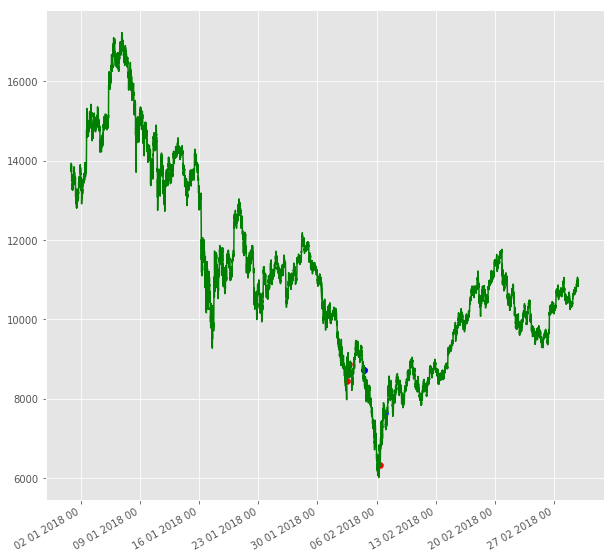

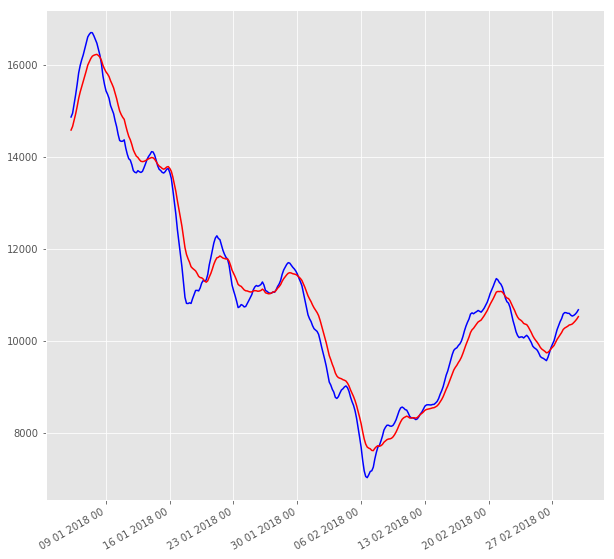

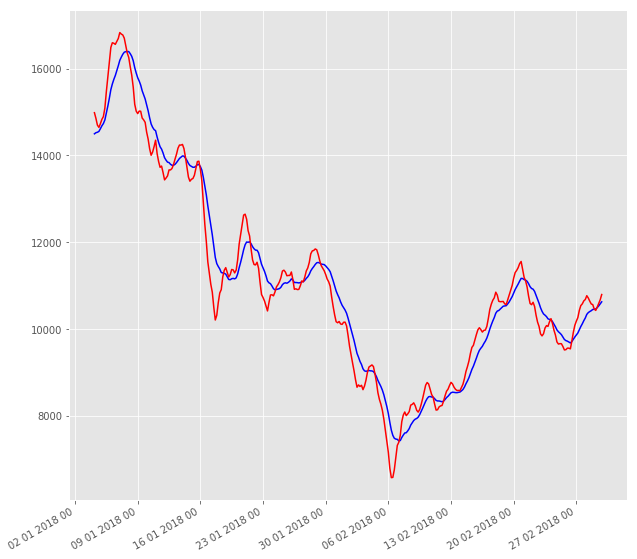

In [31]:
coin = 'USDT_BTC'
start = '2017-02-01'
stop = '2018-03-30'
plot_screen(coin, start, stop)
# plot_market_trend(coin, start_date = start)
# plot_market_trend_hist(coin, start_date = start)
plot_screen_2(coin, start, stop)
plot_screen_3(coin, start, stop)
# plot_rsi(coin, start_date = start)
# plot_screen_4(coin, n)

In [27]:
def log_return(coin, date_init = '2017-01-01', date_end = '2018-12-31'):
    
    s = select([long_positions]).\
        where(and_( long_positions.c.status  == 'closed', 
                   long_positions.c.date_ask >= date_init,
                  long_positions.c.date_ask < date_end)).\
        order_by(desc(long_positions.c.date_ask))
        
        
    rows = con.execute(s)
    long_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    long_df.columns = rows.keys()
    
    s = select([mkt_trend]).\
        where(and_(mkt_trend.c.screen == 1)).\
        order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    mkt_trend_df = mkt_trend_df[['date', 'screen', 'dif_current', 'delta_dif']] 
    merged = pd.merge(long_df, mkt_trend_df, how='inner', left_on=['date_ask'], right_on=['date'])
    merged['real_return'] = np.log((200 * (1 + merged['log_return']))/(200 + 200 * 0.0015 + 200 * (1 + merged['log_return']) * 0.0025))
    print(merged['real_return'].mean())
    print(merged['real_return'].max())
    print(merged['real_return'].min())
    print((merged['real_return'] * 100).sum())
    return merged
    
date = '2018-01-01'
date_end = '2018-03-01'
coin = 'USDT_BTC'

# print('DATE')
log_return(coin, date, date_end)
print('ALL')
df = log_return(coin)
df

0.038383284252
0.173958497216
-0.0579140978345
34.5449558268
ALL
0.038383284252
0.173958497216
-0.0579140978345
34.5449558268


,id_position,coin,strategy,size_position,date_ask,ask,date_settlement,settlement,take_profit,stop_loss,exit_date,exit_price,log_return,status,date,screen,dif_current,delta_dif,real_return
0,391,USDT_BTC,CHANNEL,50000000.0,2018-02-02 12:25:00,8439.232520,2018-03-02 01:44:20,8439.232520,10127.079024,8822.595982,2018-02-04 12:25:00,8729.368569,0.033802,closed,2018-02-02 12:25:00,1,-0.050793,0.003491,0.029167
1,392,USDT_LTC,CHANNEL,50000000.0,2018-02-02 12:40:00,122.132756,2018-03-02 01:44:20,122.132756,146.559307,124.730507,2018-02-03 04:40:00,124.565359,0.019722,closed,2018-02-02 12:40:00,1,-0.063325,0.029864,0.015489
2,393,USDT_BTC,CHANNEL,50000000.0,2018-02-02 16:25:00,8866.941084,2018-03-02 01:44:21,8866.941084,10580.584837,8822.595982,2018-02-04 12:25:00,8729.368569,-0.015637,closed,2018-02-02 16:25:00,1,-0.055139,0.969045,-0.019713
3,394,USDT_LTC,CHANNEL,50000000.0,2018-02-02 16:40:00,131.295270,2018-03-02 01:44:21,131.295270,157.554324,124.730507,2018-02-03 04:40:00,124.565359,-0.052618,closed,2018-02-02 16:40:00,1,-0.073426,0.764231,-0.057914
4,398,USDT_LTC,CHANNEL,50000000.0,2018-02-03 00:40:00,130.362258,2018-03-02 01:44:21,130.362258,156.434710,140.500552,2018-02-03 20:40:00,158.485727,0.195347,closed,2018-02-03 00:40:00,1,-0.082893,0.373587,0.173958
5,437,USDT_BTC,CHANNEL,50000000.0,2018-02-06 08:25:00,6345.819705,2018-03-02 01:44:24,6345.819705,7614.983646,7151.697286,2018-02-07 00:25:00,7656.031930,0.187698,closed,2018-02-06 08:25:00,1,-0.062549,0.165682,0.167557
6,552,USDT_LTC,CHANNEL,50000000.0,2018-02-15 20:40:00,214.336905,2018-03-02 01:44:33,214.336905,230.893666,219.133129,2018-02-18 08:40:00,216.994248,0.012322,closed,2018-02-15 20:40:00,1,0.110040,0.666409,0.008224
7,556,USDT_LTC,CHANNEL,50000000.0,2018-02-16 04:40:00,213.676198,2018-03-02 01:44:34,213.676198,235.426721,219.133129,2018-02-18 08:40:00,216.994248,0.015409,closed,2018-02-16 04:40:00,1,0.102105,1.748073,0.011261
8,558,USDT_LTC,CHANNEL,50000000.0,2018-02-16 08:40:00,212.336425,2018-03-02 01:44:34,212.336425,236.724771,219.133129,2018-02-18 08:40:00,216.994248,0.021699,closed,2018-02-16 08:40:00,1,0.098276,2.515372,0.017421


In [12]:
date = '2018-01-01'
date_end = '2018-12-31'
coin = 'USDT_BTC'
long_df = get_positions(coin, 'closed', date_end)
mkt_trend_df = get_mkt_trend(coin, date_end, 1)
mkt_trend_df['delta_dif'] = mkt_trend_df['delta_dif']
mkt_trend_df = mkt_trend_df[['date', 'screen', 'dif_current', 'delta_dif']] 
merged = pd.merge(long_df, mkt_trend_df, how='inner', left_on=['date_ask'], right_on=['date'])
    
mkt_trend_df.describe()

,screen,dif_current,delta_dif
count,318.0,318.000000,272.000000
mean,1.0,-0.006422,0.001292
std,0.0,0.031351,0.823398
min,1.0,-0.090707,-4.183506
25%,1.0,-0.030611,-0.368942
50%,1.0,-0.003041,-0.032214
75%,1.0,0.017996,0.342032
max,1.0,0.045495,3.471193


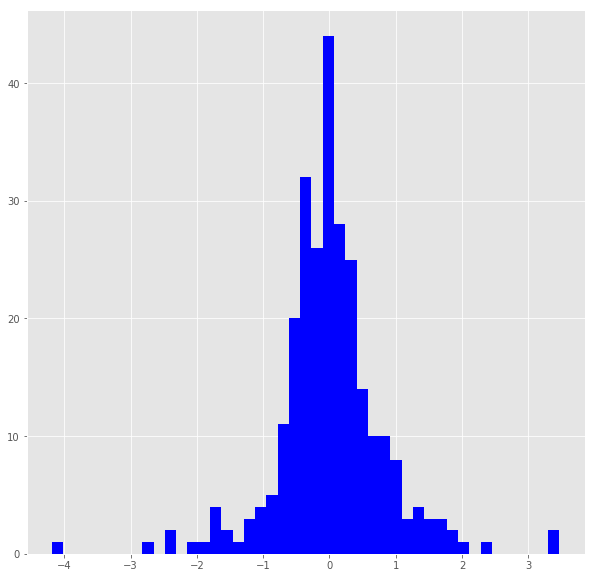

In [13]:
fig, ax = plt.subplots()
ax.hist(mkt_trend_df.dropna().delta_dif, color = 'blue', bins = 45)
plt.show()

## 

In [14]:
def calculate_vol(coin, date_end, date_init = '2017-01-01'):
    
    s = select([tickers]).\
        where(and_(tickers.c.coin == coin, tickers.c.date >= date_init, tickers.c.date <= date_end, tickers.c.screen == 0)).\
        order_by(desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    tickers_df.columns = rows.keys()
    tickers_df['Return'] = (np.log(tickers_df['price'] / tickers_df['price'].shift(-1)))
    # calculate daily standard deviation of returns
    d_std = np.std(tickers_df.Return)
    print(d_std * 100 ** 0.5)
    
date = '2018-01-01'
date_end = '2018-12-31'
coin = 'USDT_BTC'
calculate_vol(coin, date_end)

0.0508796279417
